In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
from utils import load_img, resize_crop, imshow, interleave
%matplotlib inline

# Global params

In [2]:
img_directory = '/Users/rwilliams/Desktop/celeba/training'
img_save_directory = '/Users/rwilliams/Desktop/celeba/out'
# save / load model here
model_weights_path = '/Users/rwilliams/Desktop/celeba/celeba-vaegan-weights.hdf5'
batch_size = 64
# training_set_size = 4992
training_set_size = 2048
img_size = 64

# Load training data

In [3]:
training = np.array([resize_crop(load_img(i+1, img_directory), (img_size, img_size)) for i in range(training_set_size)])

/Users/rwilliams/anaconda/envs/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# Create model and load weights

Instantiate model

In [4]:
from autoencoder import Autoencoder
from discriminator import Discriminator
from keras.optimizers import Adam

vae = Autoencoder(img_shape=(img_size, img_size, 3), batch_size=batch_size)
vae.build_model()

disc = Discriminator(img_shape=(img_size, img_size, 3), batch_size=batch_size)
disc.build_model()

Using TensorFlow backend.


(None, 256)


In [5]:
optimizer = Adam(lr=.00001)

# Train

Given real image training data, constructs a training set for the discriminator consisting of the real images, autoencoder coded then decoded images, and images generated by decoding a sample fro z. Returns tuple (training, labels).

In [6]:
def generate_disc_training_data(images, vae, batch_size, img_rows, img_cols, channels=3):
    data_set_size = images.shape[0]
    # real images encoded, then decoded
    encdec = vae.model.predict(images, batch_size=batch_size)
    # sampled from z then decoded. Do for as many as number of images.
    sampled = vae.decoder.predict(np.random.normal(size=(data_set_size, vae.zsize)), batch_size=batch_size)
        
    training = interleave(images, encdec, sampled)
    # 0 for real, 1 for fake
    labels = interleave(np.zeros(data_set_size), np.ones(data_set_size), np.ones(data_set_size))
    return (training, labels)

import keras.backend as K
def decoder_loss_factory(disc):
    def decoder_loss(y_true, y_pred):
        similarity = disc.diff_loss(y_true, y_pred)
        discriminator_out = K.log(1 - disc.model(y_pred))
        return similarity - discriminator_out
    return decoder_loss

In [ ]:
epochs = 10
for i in range(100):
    # every ten iterations, train the discriminator
    if (i % 10 == 0):
        # train discriminator
        disc_training, disc_labels = generate_disc_training_data(training, vae, batch_size, img_size, img_size)
        disc.model.compile(optimizer, 'binary_crossentropy')
        disc.model.fit(disc_training, disc_labels, epochs=epochs, batch_size=batch_size, verbose=True)

    # train vae encoder
    vae.mode('train_encoder')
    vae.model.compile(optimizer, disc.diff_loss)
    vae.model.fit(training, training, epochs=epochs, batch_size=batch_size, verbose=True)

    # train vae decoder
    vae.mode('train_decoder')
    decoder_loss = decoder_loss_factory(disc)
    vae.model.compile(optimizer, decoder_loss)
    vae.model.fit(training, training, epochs=epochs, batch_size=batch_size, verbose=True)

Epoch 1/10
6144/6144 [==============================] - 41s - loss: 0.0411    
Epoch 2/10
5952/6144 [============================>.] - ETA: 1s - loss: 0.0028

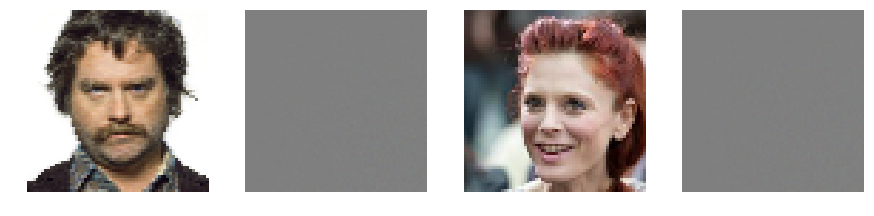

In [7]:
predictions = vae.model.predict(training[:batch_size], batch_size=batch_size)
imshow([training[0], predictions[0], training[1], predictions[1]])

In [ ]:
predictions = vae.model.predict(training[:batch_size], batch_size=batch_size)
imshow([training[0], predictions[0], training[1], predictions[1]])